# Reading image files

In [1]:
import glob
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from PIL import Image

In [22]:
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  263M  100  263M    0     0  19.9M      0  0:00:13  0:00:13 --:--:-- 22.8M


In [23]:
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip
!curl -O https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.8M  100 84.8M    0     0  16.4M      0  0:00:05  0:00:05 --:--:-- 20.9M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 99620  100 99620    0     0  89025      0  0:00:01  0:00:01 --:--:-- 89025


In [ ]:
!unzip -q GTSRB_Final_Training_Images.zip

In [5]:
# read yaml file
with open('../rb.yaml') as f:
          yaml_data = yaml.safe_load(f)

In [8]:
# load yaml file
def load_file(path):
    """ Load the file from the yaml
    
    Parameter
    --------
    path : path patter to access yaml file
    
    Return
    ------
    yaml_loaded : yaml file loaded
    
    """
    with open(path) as f:
          yaml_loaded = yaml.safe_load(f)
    return yaml_loaded

In [9]:
path_to_yaml = '../rb.yaml'
yaml_loaded = load_file(path_to_yaml)

In [25]:
TRAINING_CSV_PATH = '../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*/*.csv'

# Sur colab :
TRAINING_CSV_PATH = './GTSRB/Final_Training/Images/*/*.csv'

IMAGE_WIDTH = 30
IMAGE_HEIGHT = IMAGE_WIDTH

In [ ]:
os.path.dirname(TRAINING_CSV_PATH)

'../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/*'

In [26]:
def build_images_database(path):
    """Build a pandas DataFrame with all images information.
    
    Parameters
    ----------
    path: path pattern to read csv files containing images information
    
    Returns
    -------
    A pandas DataFrame with one line per image
    """
    df_list = []
    for filename in glob.glob(path):
        df = pd.read_csv(filename, sep=';')
        df['path'] = os.path.dirname(filename) + '/' + df['Filename']
        df_list.append(df)
    
    return pd.concat(df_list, ignore_index=True)


def build_images_list(filename_list, boxes_list=None):
    """Build a list of images as Numpy array
    
    Parameters
    ----------
    filename_list: list of images filenames
    boxes_list: optional list of boxes for clipping within images. Boxes are 4-tuples (x1, y1, x2, y2).
    
    Returns
    -------
    A list of images as Numpy arrays
    
    """
    
    # If no boxes_list is given, generate a fake boxes list with None boxes
    # image.resize will take full size images if argument box == None
    if boxes_list is None:
        boxes_list = [None] * len(filename_list)
        
    assert len(filename_list) == len(boxes_list), "filenames and boxes lists must have the same length"
    
    images_list = []
    for (filename, image_box) in zip(filename_list, boxes_list):
        image = Image.open(filename)
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
        image = np.array(image)
        images_list.append(image)
        
    return images_list


def build_classes_array(df, col_name='ClassId'):
    """Build a vector (numpy array) of classes
    
    Parameters
    ----------
    df: pandas DataFrame with a column containing classes id
    
    Returns
    -------
    Numpy array with image classes
    
    """
    return df[col_name].values


In [27]:
images_df = build_images_database(TRAINING_CSV_PATH)
images_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,32,26,6,5,27,21,30,./GTSRB/Final_Training/Images/00030/00000_0000...
1,00000_00001.ppm,32,26,6,5,27,21,30,./GTSRB/Final_Training/Images/00030/00000_0000...
2,00000_00002.ppm,31,25,5,5,26,20,30,./GTSRB/Final_Training/Images/00030/00000_0000...
3,00000_00003.ppm,33,26,5,5,28,21,30,./GTSRB/Final_Training/Images/00030/00000_0000...
4,00000_00004.ppm,34,28,5,5,29,23,30,./GTSRB/Final_Training/Images/00030/00000_0000...


In [8]:
# Reading only 200 images for the moment
images_list = build_images_list(images_df.head(200)['path'].values,
                                images_df.head(200).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                          axis=1).values)

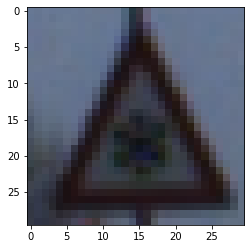

In [9]:
plt.imshow(images_list[90])

In [12]:
build_classes_array(images_df)

array([30, 30, 30, ..., 42, 42, 42])

In [13]:
images_df['ClassId'].value_counts()

2     2250
1     2220
13    2160
12    2100
38    2070
10    2010
4     1980
5     1860
25    1500
9     1470
7     1440
8     1410
3     1410
11    1320
18    1200
35    1200
17    1110
31     780
14     780
33     689
15     630
26     600
28     540
23     510
30     450
34     420
6      420
16     420
22     390
36     390
40     360
20     360
21     330
39     300
24     270
29     270
32     240
42     240
41     240
27     240
37     210
19     210
0      210
Name: ClassId, dtype: int64

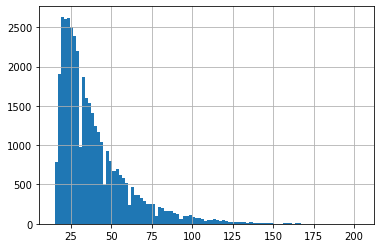

In [ ]:
(images_df['Roi.X2'] - images_df['Roi.X1']).hist(bins=100);

In [ ]:
(images_df['Roi.Y2'] - images_df['Roi.Y1']).median()

32.0

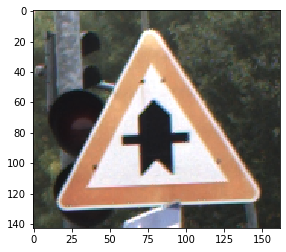

In [ ]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]))

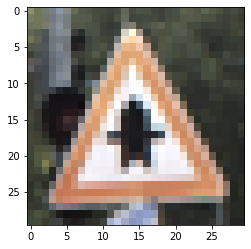

In [ ]:
plt.imshow(Image.open(images_df.query('Width == 162')['path'].values[0]).resize((30, 30)))

In [ ]:
from PIL import Image

img = Image.open('../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00000/00000_00000.ppm')

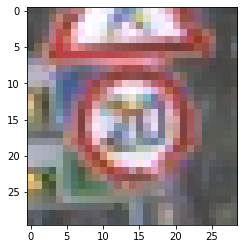

In [ ]:
plt.imshow(img)

In [ ]:
images_df.head(1)

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
0,00000_00000.ppm,29,30,5,6,24,25,0,../data/raw/GTSRB_Final_Training_Images/GTSRB/...


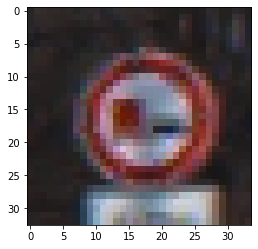

In [ ]:
img = Image.open('../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00010/00029_00010.ppm')
plt.imshow(img)

In [ ]:
img = Image.open('../data/raw/GTSRB_Final_Training_Images/GTSRB/Final_Training/Images/00010/00005_00029.ppm')

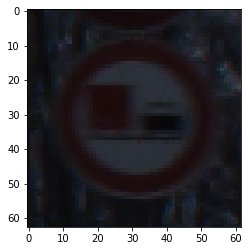

In [ ]:
plt.imshow(img)

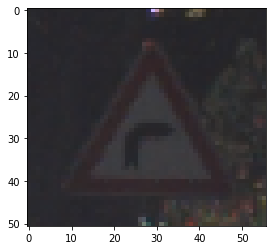

In [ ]:
plt.imshow(Image.open(images_df.query('ClassId == 20').iloc[20]['path']))

## Training the model

In [28]:
import tensorflow as tf

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

#### Take a sample to test the code

In [29]:
images_df.shape

(39209, 9)

In [55]:
N = 10_000
N = None # Take all

if N is None:
  images_list = build_images_list(images_df['path'].values,
                                  images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                        axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)
else:
  images_list = build_images_list(images_df.head(N)['path'].values,
                                  images_df.head(N).apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                            axis=1).values)
  data = np.array(images_list)
  labels = build_classes_array(images_df)[:N]

print(data.shape, labels.shape)

(39209, 30, 30, 3) (39209,)


In [56]:
#Splitting training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367,) (7842,)


In [57]:
#Converting the labels into one hot encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
print(y_train.shape, y_test.shape)

(31367, 43) (7842, 43)


In [36]:
# A faire une fois pour récupérer les informations sur la TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.112.202.154:8470']


INFO:tensorflow:Initializing the TPU system: grpc://10.112.202.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.112.202.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [58]:
with tpu_strategy.scope():
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
  model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(43, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 22, 22, 32)        25632     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 3, 3, 64)         

In [13]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [59]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31367, 30, 30, 3) (7842, 30, 30, 3) (31367, 43) (7842, 43)


In [60]:
%%time
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test))

Epoch 1/15
981/981 [==============================] - 29s 24ms/step - loss: 2.9045 - accuracy: 0.4203 - val_loss: 0.4505 - val_accuracy: 0.8984
Epoch 2/15
981/981 [==============================] - 20s 21ms/step - loss: 0.6517 - accuracy: 0.8206 - val_loss: 0.1800 - val_accuracy: 0.9584
Epoch 3/15
981/981 [==============================] - 21s 21ms/step - loss: 0.3841 - accuracy: 0.8921 - val_loss: 0.1474 - val_accuracy: 0.9639
Epoch 4/15
981/981 [==============================] - 21s 21ms/step - loss: 0.2931 - accuracy: 0.9204 - val_loss: 0.0752 - val_accuracy: 0.9821
Epoch 5/15
981/981 [==============================] - 20s 21ms/step - loss: 0.2651 - accuracy: 0.9301 - val_loss: 0.0515 - val_accuracy: 0.9871
Epoch 6/15
981/981 [==============================] - 21s 21ms/step - loss: 0.1757 - accuracy: 0.9530 - val_loss: 0.1685 - val_accuracy: 0.9555
Epoch 7/15
981/981 [==============================] - 21s 21ms/step - loss: 0.1944 - accuracy: 0.9503 - val_loss: 0.0502 - val_accuracy:

### Plot model accurary & loss

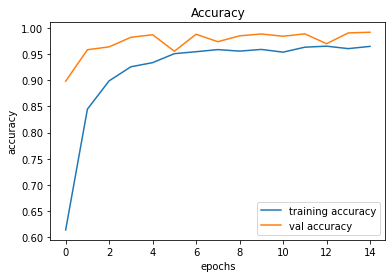

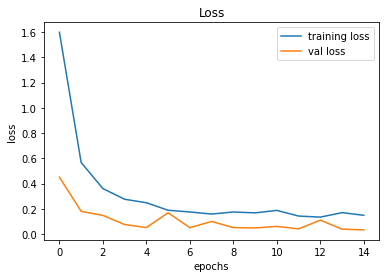

In [61]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()


## Save classifier

In [77]:
def save_classifier(model, basename):
  """Save to H5 format a TF model with a timestamp

  Paramaters
  ----------
  model: trained tf model
  basename: basename including path to use for filename

  Returns
  -------
  None
  """
  model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
  return


In [78]:
save_classifier(model, 'models/traffic_signs')

## Testing model

In [62]:
def classify_image(path, model, image_box=None):
  """Classify image by model

  Parameters
  ----------
  path: filepath to image
  model: tf/keras classifier

  Returns
  -------
  class id returned by model classifier
  """
  images_list = []
  image = Image.open(path)
  image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT), box=image_box) # box argument clips image to (x1, y1, x2, y2)
  image = np.array(image)
  images_list.append(image)
  
  return model.predict_classes(np.array(images_list))


In [65]:
image_sample = images_df.sample(1)

classify_image(image_sample['path'].values[0],
               model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([13])

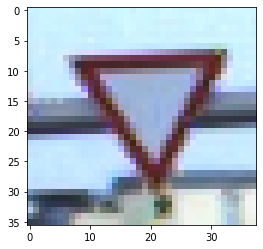

In [66]:
plt.imshow(Image.open(image_sample['path'].values[0]))

## Reloading model

In [79]:
test_model = load_model('models/traffic_signs_2021-03-19_13-51-00.h5')

In [80]:
classify_image(image_sample['path'].values[0],
               test_model,
               image_sample.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                  axis=1).values[0]
               )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([13])

## Evaluating performance

### Extracting test data

In [83]:
!unzip -q GTSRB_Final_Test_Images.zip

In [86]:
!head GTSRB/Final_Test/Images/*.csv

Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2
00000.ppm;53;54;6;5;48;49
00001.ppm;42;45;5;5;36;40
00002.ppm;48;52;6;6;43;47
00003.ppm;27;29;5;5;22;24
00004.ppm;60;57;5;5;55;52
00005.ppm;52;56;5;5;47;51
00006.ppm;147;130;12;12;135;119
00007.ppm;32;33;5;5;26;28
00008.ppm;45;50;6;5;40;45


In [87]:
!unzip GTSRB_Final_Test_GT.zip

Archive:  GTSRB_Final_Test_GT.zip
  inflating: GT-final_test.csv       


In [88]:
!head GT-final_test.csv

Filename;Width;Height;Roi.X1;Roi.Y1;Roi.X2;Roi.Y2;ClassId
00000.ppm;53;54;6;5;48;49;16
00001.ppm;42;45;5;5;36;40;1
00002.ppm;48;52;6;6;43;47;38
00003.ppm;27;29;5;5;22;24;33
00004.ppm;60;57;5;5;55;52;11
00005.ppm;52;56;5;5;47;51;38
00006.ppm;147;130;12;12;135;119;18
00007.ppm;32;33;5;5;26;28;12
00008.ppm;45;50;6;5;40;45;25


### Load text data

In [93]:
test_images_df = pd.read_csv('GT-final_test.csv', sep=';')
test_images_df['path'] = test_images_df['Filename'].apply(lambda x: './GTSRB/Final_Test/Images/' + x)
test_images_df.tail()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,path
12625,12625.ppm,42,41,5,6,37,36,12,./GTSRB/Final_Test/Images/12625.ppm
12626,12626.ppm,50,51,6,5,45,46,33,./GTSRB/Final_Test/Images/12626.ppm
12627,12627.ppm,29,29,6,6,24,24,6,./GTSRB/Final_Test/Images/12627.ppm
12628,12628.ppm,48,49,5,6,43,44,7,./GTSRB/Final_Test/Images/12628.ppm
12629,12629.ppm,32,31,6,5,27,26,10,./GTSRB/Final_Test/Images/12629.ppm


In [94]:
test_list = build_images_list(test_images_df['path'].values,
                              test_images_df.apply(lambda r: (r['Roi.X1'], r['Roi.Y1'], r['Roi.X2'], r['Roi.Y2']),
                                                   axis=1).values)
test_data = np.array(test_list)
test_labels = build_classes_array(test_images_df)


In [95]:
print(test_data.shape, test_labels.shape)

(12630, 30, 30, 3) (12630,)


In [99]:
%%time
results = test_model.predict_classes(test_data)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


CPU times: user 377 ms, sys: 95.5 ms, total: 473 ms
Wall time: 1.65 s


In [97]:
test_labels[:3]

array([16,  1, 38])

In [102]:
test_labels == results

array([ True,  True,  True, ...,  True,  True,  True])

In [103]:
(test_labels == results).sum() / test_labels.shape[0]

0.966904196357878

### Compare actual to predicted (class-level)

In [111]:
accuracy_df = pd.DataFrame()
accuracy_df['actual'] = test_labels
accuracy_df['predicted'] = results

In [112]:
accuracy_df.head()

,actual,predicted
0,16,16
1,1,1
2,38,38
3,33,33
4,11,11


In [ ]:
pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index')

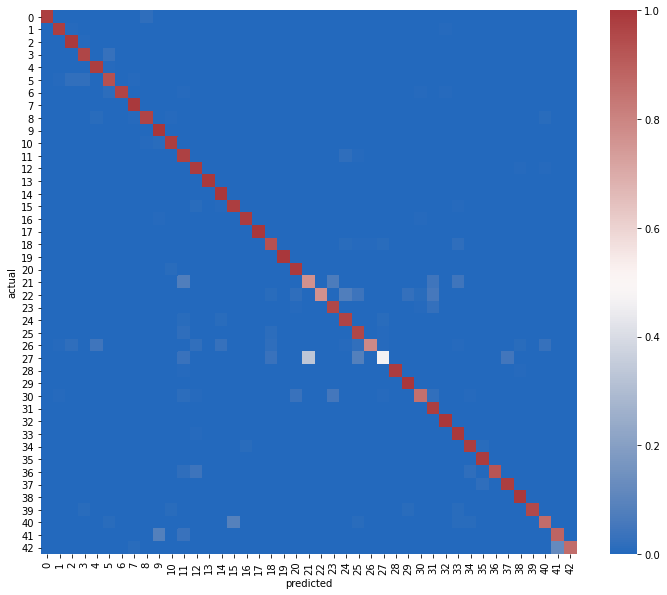

In [126]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'], normalize='index'),
            cmap='vlag',
            ax=ax);

In [ ]:
pd.crosstab(accuracy_df['actual'], accuracy_df['predicted'])

In [129]:
tf.__version__

'2.4.1'